In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice

In [251]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [252]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]


In [253]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935
Log-likelihood: -477.55688530799574


---
---
---
---
---

In [254]:
from functions_geom_DIB import geom_DIB_on_alternatives

In [255]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [256]:
def multivariate_lognormal_pdf(x, mu, sigma):
    """
    Compute the probability density function (PDF) of a multivariate lognormal distribution.

    Parameters:
        x (ndarray): Vector in log space.
        mu (ndarray): Mean vector.
        sigma (ndarray): Covariance matrix.

    Returns:
        float: Value of the PDF at x.
    """
    n = len(x)
    
    # Compute the PDF of a multivariate normal distribution
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    mvn_pdf = (1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.linalg.det(sigma)))) * np.exp(exponent)
    
    # Compute the Jacobian determinant term and remove x = 0 elements
    jacobian = np.prod(1 / x)

    pdf = jacobian * mvn_pdf

    # Compute the PDF of the multivariate lognormal distribution
    
    return pdf

---
---
---
---
---

<h2> Covariance matrix is diagonal with variance of each logcost for diagonal elements </h2>

In [8]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

sd = log_df_logcost.std()
covariance_matrix_diagonal = np.diag(sd**2)

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_diagonal), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13769/3945173557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_diagonal), axis=1)


In [9]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=40, max_iter=50000, threshold=1e-5)

Iteration: 1 out of 50000
Iteration: 2 out of 50000
Iteration: 3 out of 50000
Iteration: 4 out of 50000
Iteration: 5 out of 50000
Iteration: 6 out of 50000
Iteration: 7 out of 50000
Iteration: 8 out of 50000
Iteration: 9 out of 50000
Iteration: 10 out of 50000
Iteration: 11 out of 50000
Iteration: 12 out of 50000
Iteration: 13 out of 50000
Iteration: 14 out of 50000
Iteration: 15 out of 50000
Iteration: 16 out of 50000
Iteration: 17 out of 50000
Iteration: 18 out of 50000
Iteration: 19 out of 50000
Iteration: 20 out of 50000
Iteration: 21 out of 50000
Iteration: 22 out of 50000
Iteration: 23 out of 50000
Iteration: 24 out of 50000
Iteration: 25 out of 50000
Iteration: 26 out of 50000
Iteration: 27 out of 50000
Iteration: 28 out of 50000
Iteration: 29 out of 50000
Iteration: 30 out of 50000
Iteration: 31 out of 50000
Iteration: 32 out of 50000
Iteration: 33 out of 50000
Iteration: 34 out of 50000
Iteration: 35 out of 50000
Iteration: 36 out of 50000
Iteration: 37 out of 50000
Iteration:

KeyboardInterrupt: 

In [ ]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 1

 cluster
0    434
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0        73  123  178  3  57

 max_proba   1    2    3  4   5
cluster                       
0          49  110  236  2  37

 simulated_choice   1    2    3  4   5
cluster                              
0                 71  135  164  3  61


In [264]:
# Function to calculate the number of elements in the largest cluster
def largest_cluster_size(q_t_given_x):
    # Calculate the size of each cluster
    cluster_sizes = np.sum(q_t_given_x, axis=0)
    # Find the size of the largest cluster
    largest_cluster_size = np.max(cluster_sizes)
    return largest_cluster_size

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

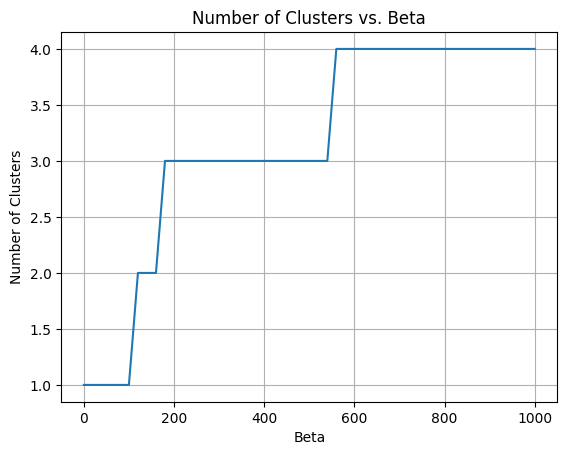

In [ ]:
betas = np.linspace(0, 1000, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

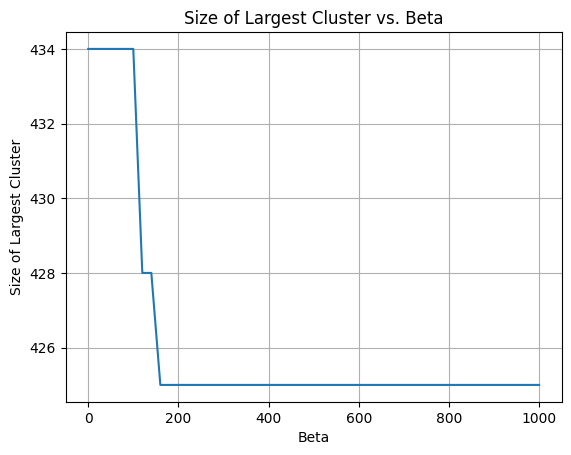

In [ ]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

---
---
---
---
---

<h2> Covariance matrix is the identity matrix </h2>

In [ ]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix_identity = np.identity(5)

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_identity), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1146/3321072539.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_identity), axis=1)


In [ ]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

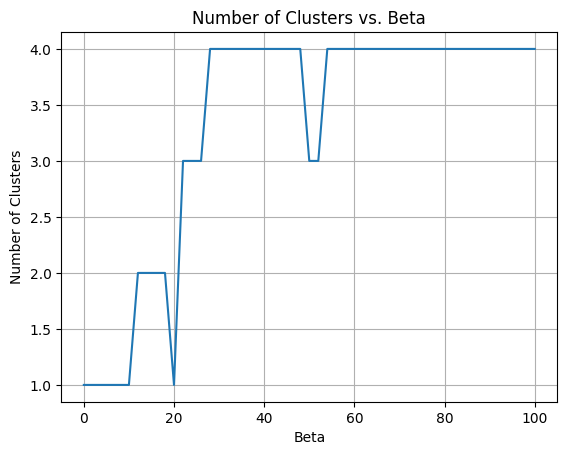

In [ ]:
betas = np.linspace(0, 100, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

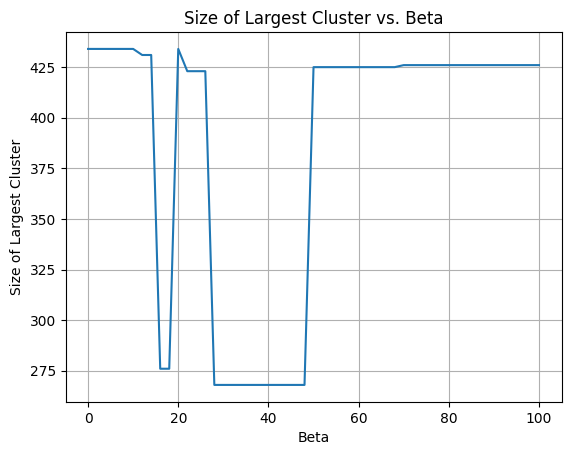

In [ ]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

---
---
---
---
---

<h2> Covariance matrix is diagonal with variance as diagonal elements. Add correlation between logcost1 and logcost2 </h2>

In [260]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix_full = log_df_logcost.cov()
# Replace all off-diagonal elements with zero except for covariance between cost1 and cost2
covariance12 = covariance_matrix_full.loc['logcost1', 'logcost2']
variance1 = covariance_matrix_full.loc['logcost1', 'logcost1']
variance2 = covariance_matrix_full.loc['logcost2', 'logcost2']
variance3 = covariance_matrix_full.loc['logcost3', 'logcost3']
variance4 = covariance_matrix_full.loc['logcost4', 'logcost4']
variance5 = covariance_matrix_full.loc['logcost5', 'logcost5']

covariance_matrix = np.array([[1, 0.9, 0, 0, 0],
                               [0.9, 1, 0, 0, 0],
                               [0, 0, 1, 0, 0],
                               [0, 0, 0, 1, 0],
                               [0, 0, 0, 0, 1]])

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13769/829470007.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix), axis=1)


In [270]:
log_df_logcost.cov()

,logcost1,logcost2,logcost3,logcost4,logcost5
logcost1,0.095753,0.064655,0.029184,-0.010677,-0.016703
logcost2,0.064655,0.053884,0.025420,-0.011818,-0.030760
logcost3,0.029184,0.025420,0.023921,-0.006042,-0.060515
logcost4,-0.010677,-0.011818,-0.006042,0.070142,0.018625
logcost5,-0.016703,-0.030760,-0.060515,0.018625,0.471618


In [261]:
covariance_matrix

array([[1. , 0.9, 0. , 0. , 0. ],
       [0.9, 1. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 1. ]])

In [262]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

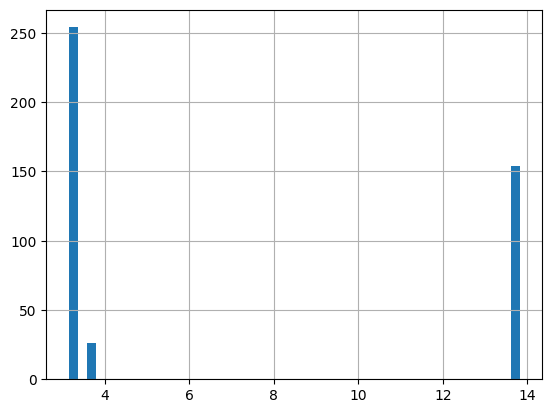

In [282]:
data['logcost5'].hist(bins = 50)
plt.show()

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000


Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out of 5000
Iteration: 42 out of 5000
Iteration: 43 out

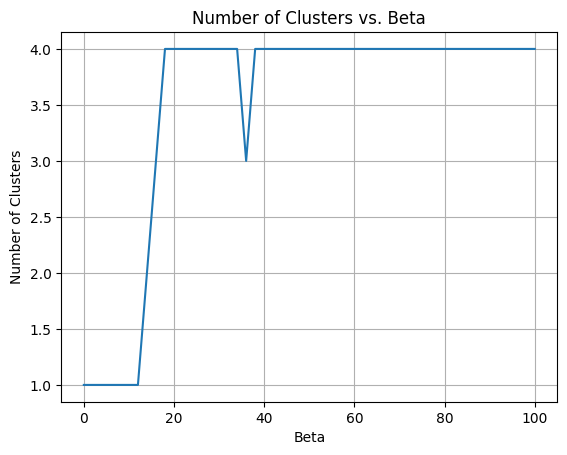

In [265]:
betas = np.linspace(0, 100, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

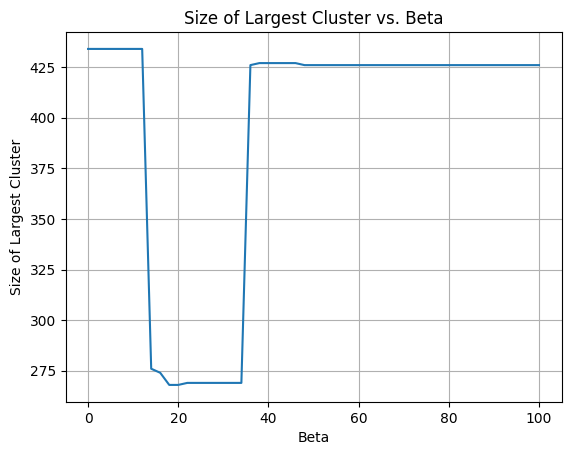

In [266]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [269]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=25, max_iter=5000, threshold=1e-5)

# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000


Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out of 5000
Iteration: 42 out 

---
---
---
---
---

<h2> Covariance matrix is the identity matrix and we add some covariance between logcost1 and logcost2 </h2>

In [ ]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix_full = log_df_logcost.cov()
# Replace all off-diagonal elements with zero except for covariance between cost1 and cost2
covariance12 = covariance_matrix_full.loc['logcost1', 'logcost2']
covariance13 = covariance_matrix_full.loc['logcost1', 'logcost3']
covariance23 = covariance_matrix_full.loc['logcost2', 'logcost3']
variance1 = covariance_matrix_full.loc['logcost1', 'logcost1']
variance2 = covariance_matrix_full.loc['logcost2', 'logcost2']
variance3 = covariance_matrix_full.loc['logcost3', 'logcost3']
variance4 = covariance_matrix_full.loc['logcost4', 'logcost4']
variance5 = covariance_matrix_full.loc['logcost5', 'logcost5']

covariance_matrix = np.array([[variance1, covariance12, covariance13, 0, 0],
                               [covariance12, variance2, covariance23, 0, 0],
                               [covariance13, covariance23, variance3, 0, 0],
                               [0, 0, 0, variance4, 0],
                               [0, 0, 0, 0, variance5]])

covariance_matrix_increased = covariance_matrix * 50

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1146/1651784863.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)


In [ ]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

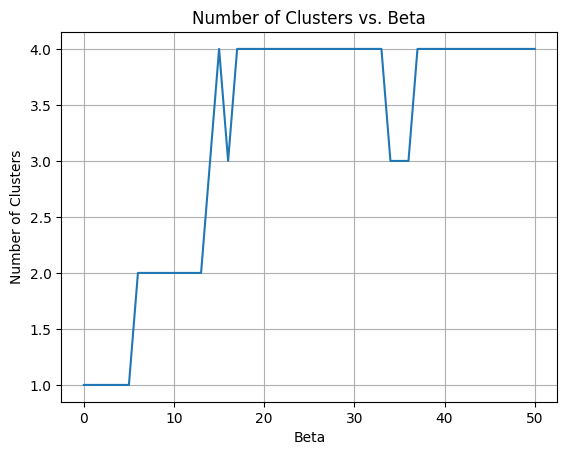

In [ ]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-5)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

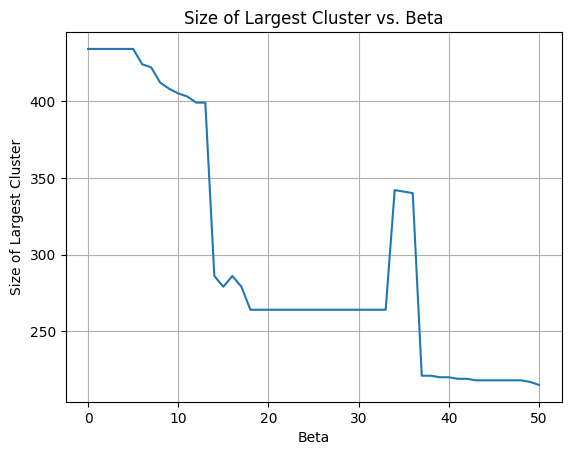

In [ ]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [ ]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=14, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [ ]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
0    286
2    113
1     35
Name: count, dtype: int64

 choice    1   2    3  4   5
cluster                    
0        64  97  111  1  13
1         1   1    4  0  29
2         8  25   63  2  15

 max_proba   1   2    3  4   5
cluster                      
0          49  99  138  0   0
1           0   0    1  0  34
2           0  11   97  2   3

 simulated_choice   1    2   3  4   5
cluster                             
0                 62  115  97  0  12
1                  0    2   4  0  29
2                  9   18  63  3  20


---
---
---
---
---

<h2> Test with full covariance matrix to see if some clusters are bigger with all the covariances </h2>

In [ ]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix_full = log_df_logcost.cov()
covariance_matrix_full = covariance_matrix_full * 100

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_full), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1146/1418553458.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_full), axis=1)


In [ ]:
covariance_matrix_full

,logcost1,logcost2,logcost3,logcost4,logcost5
logcost1,9.575287,6.465456,2.918444,-1.067718,-1.670272
logcost2,6.465456,5.388416,2.541997,-1.181781,-3.075962
logcost3,2.918444,2.541997,2.392098,-0.604227,-6.051508
logcost4,-1.067718,-1.181781,-0.604227,7.014245,1.862492
logcost5,-1.670272,-3.075962,-6.051508,1.862492,47.161771


In [ ]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000


Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out of 5000
Iteration: 42 out 

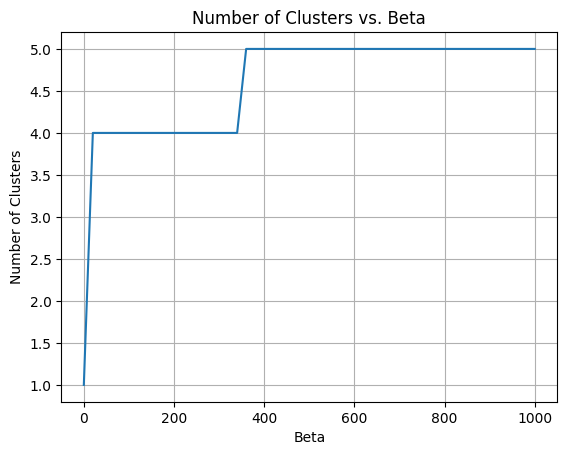

In [ ]:
betas = np.linspace(0, 1000, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

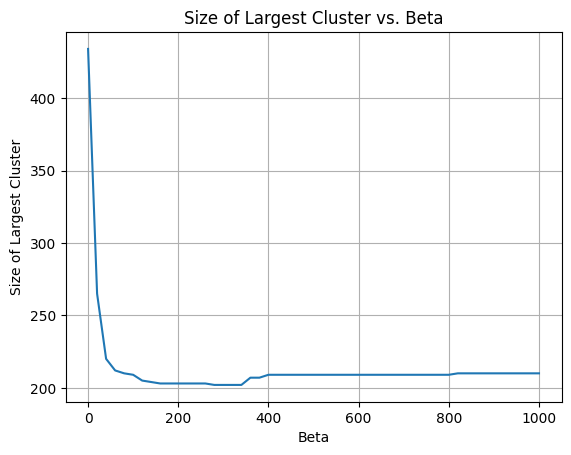

In [ ]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [ ]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=200, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [ ]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
0    203
2    133
1     96
4      2
Name: count, dtype: int64

 choice    1   2   3  4   5
cluster                   
0        55  66  72  1   9
1         4  12  42  0  38
2        14  45  63  1  10
4         0   0   1  1   0

 max_proba   1   2   3  4   5
cluster                     
0          49  63  91  0   0
1           0   0  59  0  37
2           0  47  86  0   0
4           0   0   0  2   0

 simulated_choice   1   2   3  4   5
cluster                            
0                 50  81  67  0   5
1                  5   9  38  1  43
2                 16  45  58  1  13
4                  0   0   1  1   0


---
---
---
---
---

<h2> Add covariance between alternatives 3 and 5 to see if the algorithm can separate alternatives 1,2 and 3 </h2>

In [ ]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix_full = log_df_logcost.cov()
# Replace all off-diagonal elements with zero except for covariance between cost1 and cost2
covariance35 = covariance_matrix_full.loc['logcost3', 'logcost5']
variance1 = covariance_matrix_full.loc['logcost1', 'logcost1']
variance2 = covariance_matrix_full.loc['logcost2', 'logcost2']
variance3 = covariance_matrix_full.loc['logcost3', 'logcost3']
variance4 = covariance_matrix_full.loc['logcost4', 'logcost4']
variance5 = covariance_matrix_full.loc['logcost5', 'logcost5']

covariance_matrix = np.array([[variance1, 0, 0, 0, 0],
                               [0, variance2, 0, 0, 0],
                               [0, 0, variance3, 0, covariance35],
                               [0, 0, 0, variance4, 0],
                               [0, 0, covariance35, 0, variance5]])

covariance_matrix_increased = covariance_matrix * 50

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1146/1407603531.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)


In [ ]:
covariance_matrix_increased

array([[ 4.78764327,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.69420802,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.19604907,  0.        , -3.02575381],
       [ 0.        ,  0.        ,  0.        ,  3.50712226,  0.        ],
       [ 0.        ,  0.        , -3.02575381,  0.        , 23.58088557]])

In [ ]:
np.linalg.eigvals(covariance_matrix_increased)

array([ 0.79426996, 23.98266468,  4.78764327,  2.69420802,  3.50712226])

In [ ]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000


Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of 5000
Iteration: 41 out of 5000
Iteration: 42 out of 5000
Iteration: 43 out

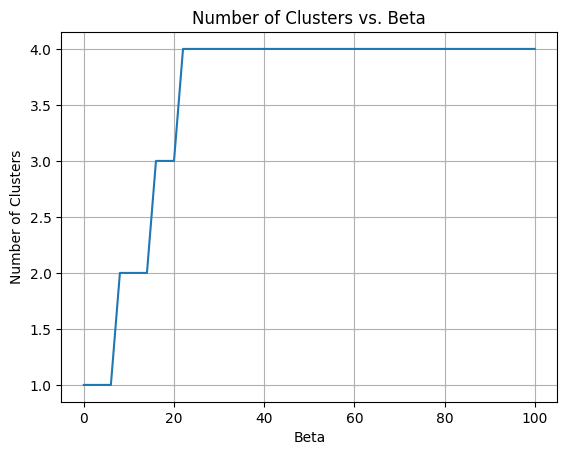

In [ ]:
betas = np.linspace(0, 100, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

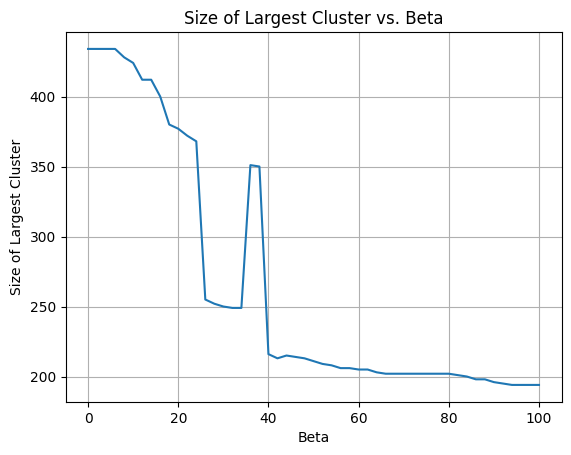

In [ ]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [ ]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=25, max_iter=5000, threshold=1e-6)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [ ]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
0    257
2    137
1     38
3      2
Name: count, dtype: int64

 choice    1   2   3  4   5
cluster                   
0        62  87  95  1  12
1         1   1   4  0  32
2        10  35  78  1  13
3         0   0   1  1   0

 max_proba   1   2    3  4   5
cluster                      
0          49  94  114  0   0
1           0   0    2  0  36
2           0  16  120  0   1
3           0   0    0  2   0

 simulated_choice   1    2   3  4   5
cluster                             
0                 61  100  86  0  10
1                  0    3   5  0  30
2                 10   32  72  2  21
3                  0    0   1  1   0


---
---
---
----
---

<h2> Full covariance matrix again </h2>

In [72]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

covariance_matrix_full = log_df_logcost.cov()

covariance_matrix_increased = covariance_matrix_full * 50

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13769/2195152351.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)


In [73]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

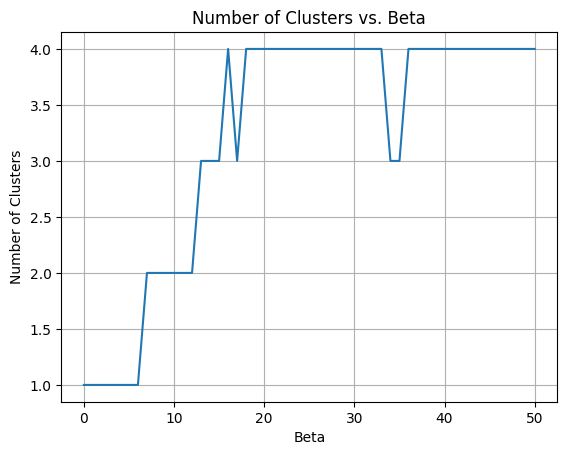

In [ ]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

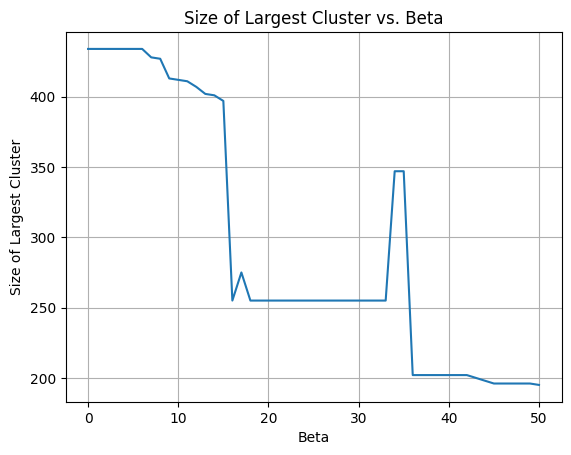

In [ ]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [74]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=30, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [77]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
0    302
2     62
1     50
3     20
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
0        65  101  122  1  13
1         3    3   22  0  22
2         5   18   32  1   6
3         0    1    2  1  16

 max_proba   1   2    3  4   5
cluster                      
0          27  85  190  0   0
1           0   0   24  0  26
2           0   0   62  0   0
3           0   0    0  2  18

 simulated_choice   1    2    3  4   5
cluster                              
0                 61  113  118  0  10
1                  3    5   18  1  23
2                  6    9   35  1  11
3                  0    0    2  1  17


---
---
---
---
---


In [234]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [235]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)


Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935
Log-likelihood: -477.55688530799574


In [236]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [237]:
# Calculate the loglikelihood of the model on simulated choices
simluated_proba = (data['simulated_choice'] == 1) * data['P_1'] + \
                    (data['simulated_choice'] == 2) * data['P_2'] + \
                    (data['simulated_choice'] == 3) * data['P_3'] + \
                    (data['simulated_choice'] == 4) * data['P_4'] + \
                    (data['simulated_choice'] == 5) * data['P_5']

# Replace zero probabilities with small value to avoid LL = -inf
epsilon = 1e-20
simluated_proba[simluated_proba == 0] = epsilon
    
# Calculate log-likelihood 
LL_sim = simluated_proba.apply(np.log).sum()
LL_sim

-471.45488085531684

In [238]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone_NLM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1_NLM'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2_NLM'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3_NLM'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4_NLM'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5_NLM'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P_NLM'] = (data['choice'] == 1) * data['P_1_NLM'] + \
                (data['choice'] == 2) * data['P_2_NLM'] + \
                (data['choice'] == 3) * data['P_3_NLM'] + \
                (data['choice'] == 4) * data['P_4_NLM'] + \
                (data['choice'] == 5) * data['P_5_NLM']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P_NLM'] == 0, 'P_NLM'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P_NLM'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [239]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_NLM)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04
AIC: 960.4386663193137
BIC: 988.9499780580165
Log-likelihood: -473.21933315965686


In [240]:
# Calculate the loglikelihood of the model on simulated choices
simluated_proba = (data['simulated_choice'] == 1) * data['P_1_NLM'] + \
                    (data['simulated_choice'] == 2) * data['P_2_NLM'] + \
                    (data['simulated_choice'] == 3) * data['P_3_NLM'] + \
                    (data['simulated_choice'] == 4) * data['P_4_NLM'] + \
                    (data['simulated_choice'] == 5) * data['P_5_NLM']

# Replace zero probabilities with small value to avoid LL = -inf
epsilon = 1e-20
simluated_proba[simluated_proba == 0] = epsilon
    
# Calculate log-likelihood 
LL_sim = simluated_proba.apply(np.log).sum()
LL_sim

-479.881592264759

In [241]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5",
#                       "BETA_COST", "lambda_measured", "lambda_flat"]


# DEFINE LIKELIHOOD FUNCTION
def log_likelihood_telephone_CNLM2(beta, data):
    alpha_3_with_measured = 0.8
    alpha_3_with_flat = 1 - alpha_3_with_measured

    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1']
    data['U_2'] = beta[4] * data['logcost2']
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    # combined utility terms inside nests
    data['log_U_measured_3'] = np.log((alpha_3_with_measured * data['avail3'] * np.exp(data['U_3'])) ** (1 / beta[5]) + \
                             data['avail1'] * np.exp(data['U_1']) ** (1 / beta[5]) + \
                             data['avail2'] * np.exp(data['U_2']) ** (1 / beta[5]))
    data['log_U_flat_3'] = np.log((alpha_3_with_flat * data['avail3'] * np.exp(data['U_3'])) ** (1 / beta[6]) + \
                            data['avail4'] * np.exp(data['U_4']) ** (1 / beta[6]) + \
                            data['avail5'] * np.exp(data['U_5']) ** (1 / beta[6]))

    # Nest probabilities
    data['log_P_nest_measured_3'] = data['log_U_measured_3'] * beta[5] - \
                                np.log(np.exp(data['log_U_measured_3']) ** beta[5] + \
                                       np.exp(data['log_U_flat_3']) ** beta[6])
    data['log_P_nest_flat_3'] = np.log(1 - np.exp(data['log_P_nest_measured_3']))

    # Within nest probabilities
    data['log_P_1_in_measured_3'] = np.log(data['avail1']) + data['U_1'] / beta[5] - data['log_U_measured_3']
    data['log_P_3_in_measured_3'] = (np.log(data['avail3']) + np.log(alpha_3_with_measured) + \
                                     data['U_3']) / beta[5] - data['log_U_measured_3']
    data['log_P_2_in_measured_3'] = np.log(1 - np.exp(data['log_P_1_in_measured_3']) - \
                                           np.exp(data['log_P_3_in_measured_3']))
    data['log_P_4_in_flat_3'] = np.where(data['avail4'] == 0, -np.inf,
                                     np.log(data['avail4']) + data['U_4'] / beta[6] - data['log_U_flat_3'])
    data['log_P_3_in_flat_3'] = (np.log(data['avail3']) + np.log(alpha_3_with_flat) + \
                                 data['U_3']) / beta[6] - data['log_U_flat_3']
    data['log_P_5_in_flat_3'] = np.where(data['avail5'] == 0, -np.inf, 
                                         np.log(1 - np.exp(data['log_P_4_in_flat_3']) - \
                                                np.exp(data['log_P_3_in_flat_3'])))

    # Full probabilities
    data['P_1_CNLM'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_1_in_measured_3'])
    data['P_2_CNLM'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_2_in_measured_3'])
    data['P_3_CNLM'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_3_in_measured_3']) + \
                np.exp(data['log_P_nest_flat_3'] + data['log_P_3_in_flat_3'])
    data['P_4_CNLM'] = np.exp(data['log_P_nest_flat_3'] + data['log_P_4_in_flat_3'])
    data['P_5_CNLM'] = np.exp(data['log_P_nest_flat_3'] + data['log_P_5_in_flat_3'])

    # Calculate probability for chosen alternative for each row
    data['P_CNLM'] = (data['choice'] == 1) * data['P_1_CNLM'] + \
                (data['choice'] == 2) * data['P_2_CNLM'] + \
                (data['choice'] == 3) * data['P_3_CNLM'] + \
                (data['choice'] == 4) * data['P_4_CNLM'] + \
                (data['choice'] == 5) * data['P_5_CNLM']

    # Calculate log-likelihood 
    LL = data['P_CNLM'].apply(np.log).sum()

    return -LL  # We minimize negative log-likelihood

In [242]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_CNLM2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -1.372220              0.372372    -3.685084  2.580412e-04
1            ASC_3  1.961806              0.355000     5.526210  5.702299e-08
2            ASC_4  2.078906              1.009319     2.059713  4.003164e-02
3            ASC_5  3.651374              0.678834     5.378892  1.237317e-07
4        BETA_COST -3.142260              0.452419    -6.945459  1.413292e-11
5  lambda_measured  2.081044              0.394699     5.272487  2.142242e-07
6      lambda_flat  1.872667              0.778225     2.406330  1.653763e-02
AIC: 960.5626689343441
BIC: 989.0739806730469
Log-likelihood: -473.28133446717203


In [243]:
# Calculate the loglikelihood of the model on simulated choices
simluated_proba = (data['simulated_choice'] == 1) * data['P_1_CNLM'] + \
                    (data['simulated_choice'] == 2) * data['P_2_CNLM'] + \
                    (data['simulated_choice'] == 3) * data['P_3_CNLM'] + \
                    (data['simulated_choice'] == 4) * data['P_4_CNLM'] + \
                    (data['simulated_choice'] == 5) * data['P_5_CNLM']

# Replace zero probabilities with small value to avoid LL = -inf
epsilon = 1e-20
simluated_proba[simluated_proba == 0] = epsilon
    
# Calculate log-likelihood 
LL_sim = simluated_proba.apply(np.log).sum()
LL_sim

-470.34512097751485

In [244]:
LL_sim_vector_NLM = []
LL_sim_vector_CNLM = []
for i in range(1000): 
    np.random.seed(i)
    data['simulated_choice'] = data.apply(simulate_choice, axis=1)
    simulated_proba_NLM = (data['simulated_choice'] == 1) * data['P_1_NLM'] + \
                    (data['simulated_choice'] == 2) * data['P_2_NLM'] + \
                    (data['simulated_choice'] == 3) * data['P_3_NLM'] + \
                    (data['simulated_choice'] == 4) * data['P_4_NLM'] + \
                    (data['simulated_choice'] == 5) * data['P_5_NLM']
    simulated_proba_CNLM = (data['simulated_choice'] == 1) * data['P_1_CNLM'] + \
                    (data['simulated_choice'] == 2) * data['P_2_CNLM'] + \
                    (data['simulated_choice'] == 3) * data['P_3_CNLM'] + \
                    (data['simulated_choice'] == 4) * data['P_4_CNLM'] + \
                    (data['simulated_choice'] == 5) * data['P_5_CNLM']

    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    simulated_proba_NLM[simulated_proba_NLM == 0] = epsilon
    simulated_proba_CNLM[simulated_proba_CNLM == 0] = epsilon
    
    # Calculate log-likelihood 
    LL_sim_NLM = simulated_proba_NLM.apply(np.log).sum()
    LL_sim_CNLM = simulated_proba_CNLM.apply(np.log).sum()

    LL_sim_vector_NLM.append(LL_sim_NLM)
    LL_sim_vector_CNLM.append(LL_sim_CNLM)

In [246]:
# Compare LL_sim_vector_CNLM and LL_sim_vector_NLM to know how many times the CNLM model is better than the NLM model
better_CNLM = 0
better_NLM = 0
for i in range(1000):
    if LL_sim_vector_CNLM[i] > LL_sim_vector_NLM[i]:
        better_CNLM += 1
    else:
        better_NLM += 1

better_CNLM, better_NLM

(804, 196)

In [248]:
log_df_logcost.corr()

,logcost1,logcost2,logcost3,logcost4,logcost5
logcost1,1.000000,0.900104,0.609798,-0.130284,-0.078599
logcost2,0.900104,1.000000,0.708035,-0.192228,-0.192955
logcost3,0.609798,0.708035,1.000000,-0.147510,-0.569743
logcost4,-0.130284,-0.192228,-0.147510,1.000000,0.102402
logcost5,-0.078599,-0.192955,-0.569743,0.102402,1.000000


In [249]:
log_df_logcost.cov() * 50

,logcost1,logcost2,logcost3,logcost4,logcost5
logcost1,4.787643,3.232728,1.459222,-0.533859,-0.835136
logcost2,3.232728,2.694208,1.270998,-0.590891,-1.537981
logcost3,1.459222,1.270998,1.196049,-0.302113,-3.025754
logcost4,-0.533859,-0.590891,-0.302113,3.507122,0.931246
logcost5,-0.835136,-1.537981,-3.025754,0.931246,23.580886
